In [1]:
from data_prep.exp import experiment
from data_prep.analyzer import analyzer
from mea_reservoir.lasso_node import lasso
from mea_reservoir.mea_node import mea_res
from data_prep.utils import save_pickle_file,adjust_font_dimension,open_pickle_file,check_if_file_exist,plot_channel_prediction,plot_single_exp_cm_analysis
import os
import pickle
import numpy as np
from time import time
import pandas as pd
import shutil
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In this notebook we will go trought the analysis of one simulation data to explain the different analysis steps

Let's start by defining the input and output path.
For simulation data we need to provide the path to the folder obtained as result after running the simulation module

In [2]:
INPUT_PATH = 'simulation_example/60_pop_stim_full_inh__isol_pto_1'
OUTPUT_PATH='/home/giorgio/Desktop/fin_11_01/training_plot' # desired output path

Let's define the seed that we'll be used trough the analysis

In [3]:
seed=420 # if not specified a seed of 1 will be used

Let's now create an instance of the experiment class. 
This class takes as input the path to an experimental recording or simulation data folder and, after identifiying the data type (simulation or experimental recording) it accomodates the data and parameter in two python dictionary, the data dictionary and params dictionary, respectively.

In particular, when initialized, the experiment class takes care to divide the simulation (or experimental data) in two sets, defined as 'background' and 'stimulation'.

The 'background' data is an matrix (n_ch x m) containing the spike timestamp (m) for all channel (n_ch) simulated (or experimentally recorded) during background activity. we will look at the 'stimulation' data structure later.

The output of different analysis steps and eventual parameters used in those are added troughtout the analysis to the data and params dictionaries.

Once the experiment instance has been created, we can pass this to an instance of the analyzer class.
Such class is a wrapper for all the different method for pre-processing, dataset generation, and MEArc model analysis.

In [4]:
adjust_font_dimension(title_size=20,legend_size=25,label_size=18,x_ticks=15,y_ticks=15) # function that allow to change matplotlib config parameters

In [4]:
exp=experiment(path=INPUT_PATH,results_path=OUTPUT_PATH,seed=seed)
anl = analyzer(exp)

We can now start the analysis by computing the ISIth from the "background" data. 
channel_list is just a list with channel's indexes.

The identified ISIth is saved in the experiment params dictionary under the key 'isith'.

In [5]:
background_data,channel_list = anl.retrieve_data_exp('background')

In [9]:
print(f'background data simension: {background_data.shape}')

background data simension: (60, 6215)


In [57]:
anl.raster_plot(start=100000,stop=140000,filt=False)
anl.plot_single_population_isi(36)


  ![image info](simulation_example/figures_analysis_noteboook/channel_36_isi_histogram.svg)
  ![image info](simulation_example/figures_analysis_noteboook/raster_plot.svg)






In [6]:
anl.calculate_isith(background_data) # 

In [7]:
isith = anl.retrieve_param_exp('isith')
print(f'ISI threshold: {isith} ms')

ISI threshold: 19.95 ms


![image info](simulation_example/figures_analysis_noteboook/cumulative_isi_histogram.svg)



Burst events are then calculated using the identified ISIth.
(check section II.a Spike and Burst Detection in the supplementary material for a more precise explanation of the methods used)

In [7]:
anl.calculate_burst(background_data,channel_list,ABR_th=0) # ABR_th can be used to filter channels with an average bursting rate smaller than the threshold

burst_data = anl.retrieve_data_exp('burst') # retrieve burst data

burst_data is a dictionary as key:value the channel index(key) and a list of list as value. 
Each identified burst for that channel is saved as a list [burst start(ms),burst end(ms),spikes number,burst total duration(ms)].

In [13]:
burst_example = burst_data['0'][0] # first burst event identified for channel with index 0
print(f'burst start:{burst_example[0]} ms\nburst end:{burst_example[1]} ms\nspikes number: {burst_example[2]}\nburst duration: {burst_example[3]} ms')

burst start:3367.4 ms
burst end:3378.56 ms
spikes number: 5
burst duration: 11.159999999999854 ms


From burst data the IBI threshold is then computed. The IBIth is used as integration time, an important parameter in the dataset generation and training of MEArc model.

In [8]:
try:
    anl.calculate_ibith(burst_data)
except:
    print('No IBITh computable, skipping analysis')
    

![image info](simulation_example/figures_analysis_noteboook/cumulative_ibi_histogram.svg)

In [11]:
ibith = anl.retrieve_param_exp('ibith')
print(f'IBI threshold: {ibith} ms')

IBI threshold: 2 ms


After computing the burst data for each channel, network burst analysis can be done. 
The network burst windows (start and end of NB) will be used as training data for the MEArc model.

The network burst data will be again saved in the data dictionary of the experiment class, under the key 'network_burst'

In [9]:
anl.calculate_network_burst(burst_data)

In [10]:
nb_data,nb_length = anl.retrieve_data_exp('network_burst')
# nb_data is a list containing the timestamp of the first spike of each Network burst, 
# while nb_length is a list containing the duration of each.


Once network bursts are identified, training and validation data can be created.

For each network burst, a window is generated [NB start,NB end+extra_step]. The integration time is now used to bin the background data in this NB window, and for each bin the total number of action potential is computed.
Thus we obtain a matrix that represents the  binned activity of each channel during that Network burst.
This process is repeated for each network burst. As we assume that each network burst is indipendent we then shuffle the order of such windows, and then splitted in training and validation datasets.

*null steps (bin with zero activity in NB window are added to help the model distinguish between NBs eventually happening closer one to each other)


In [11]:
anl.create_training_data(0.85,extra_steps=30)

In [12]:
# prepering training and validation data
norm_factor = exp.get_param('norm_factor_back')
training = exp.get_data('training')
training = [tr/norm_factor for tr in training]

validation = exp.get_data('validation')
validation = [val/norm_factor for val in validation]


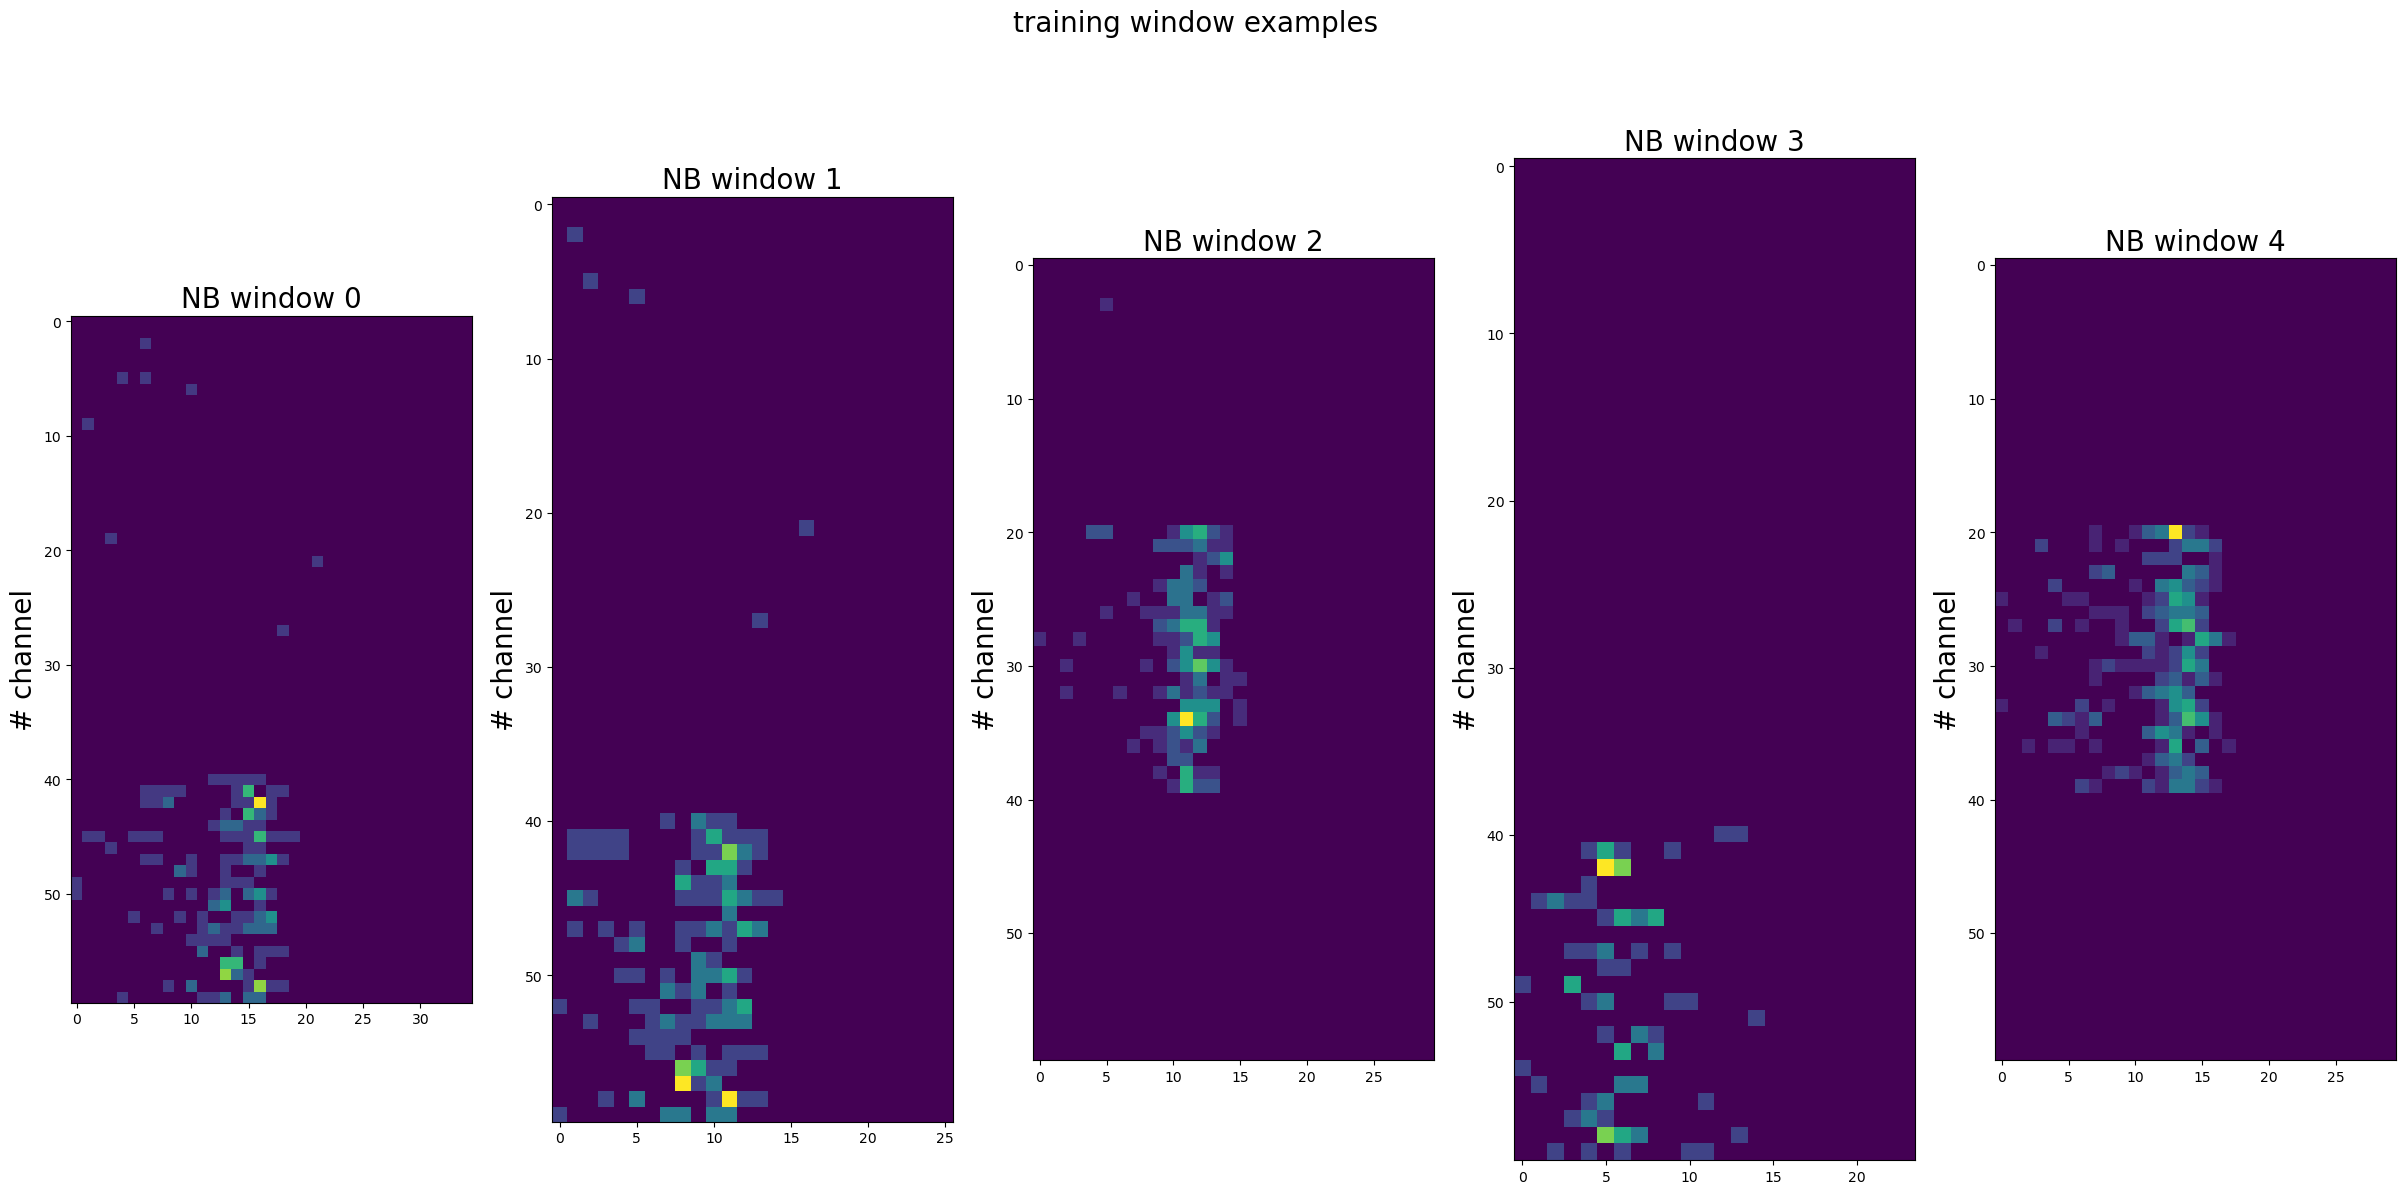

In [15]:
fig,axs = plt.subplots(1,5,figsize=(30,20))
axs = axs.flatten()

for i in range(5):
    axs[i].imshow(training[i])
    axs[i].set_ylabel('# channel',fontsize=20)
    axs[i].set_title(f'NB window {i}',fontsize=20)
fig.subplots_adjust(top=1.2)
fig.suptitle('training window examples',fontsize=20)

plt.show()

Before proceeding with training the model we can have a look to the 'stimulation' data.




In [14]:
stim_data = anl.retrieve_data_exp('stimulation')

In [21]:
stim_data.keys()

dict_keys([19, 11, 14])

Stimulation data is a dictionary with key:value pairs represented by channel index as key, and as value a list containing [stimulation protocol,(n_ch x m) matrix,list of channel index of the matrix].

stimulation protocol is a pandas dataframe composed by three columns:
+ start: start of stimulation in ms
+ end: end of stimulation in ms
+ target: targeted channel

each row represents a repetition of the stimulus.

In [39]:
stim_data[11][0] # stimulation protocol

,start,end,target
0,150000.0,150002.0,11
1,151000.0,151002.0,11
2,152000.0,152002.0,11
3,153000.0,153002.0,11
4,154000.0,154002.0,11
5,155000.0,155002.0,11
6,156000.0,156002.0,11
7,157000.0,157002.0,11
8,158000.0,158002.0,11
9,159000.0,159002.0,11


starting from the 'stimulation' matrix we can calculate the PSTH window for each stimulated channel (target)

In [21]:
anl.calculate_psth(steps_number=20) # steps number define how many time bins we consider for calculation

we can plot the PSTH windows, one for each stimulated channel

Channel 11             |  Channel 14            | Channel 19
:-------------------------:|:-------------------------:|:-------------------------:|
![](simulation_example/figures_analysis_noteboook/gt_psth_stim_protocol_11.svg)  |  ![](simulation_example/figures_analysis_noteboook/gt_psth_stim_protocol_14.svg) | ![](simulation_example/figures_analysis_noteboook/gt_psth_stim_protocol_19.svg)

Those PSTH windows represent the ground truth of stimulating the simulated neural network (or experimentally recorded neurons for experimental data). This is what we want to predict using the MEArc model.

Moreover, after training the MEArc model can provide an estimate of the connectivity matrix between channels (check 5.4 Linearized Model and Connectivity Analysis)

In [22]:
analyzed_stim_dict =exp.get_data('processed_stimulation') # processed_stimulation contains the ground truth PSTH

Now we can run the MEArc model.

Few parameters must be selected:
+ alpha: the memory parameter, it determines the importance of the reservoir state [i] on the reservoir state [i+1]
+ m: dimension of reservoir layer 
+ repeat: as the matrices defining the model are randomly initialized, for the same alpha and m values, many repeat of the model are computed and the average prediction of such models is then considered as final prediction
+ fit_intercept: whether to fit the intercept for the lasso (defalut = False). Check sk-learn implementation for details
+ save_data: if set to True, the set of MEArc trained models are saved in a pickle file. **Attention** if many MEArc model are trained, the pickle file can become quite large

In [13]:
import time
start = time.time()

mearc_characterized_dict = anl.characterize_meaRC(training=training,validation=validation,alphas=[0.5],ms=[10],repeat=1,n_jobs=10,fit_intercept=False,save_data=True,rng=seed)
end= time.time()
print(end-start)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

148.9905354976654


In [18]:
mm = mearc_characterized_dict[5][0.5][0]

In [19]:
ln = mm.get_node(mm.hypers['learning_method'])

In [20]:
wout = ln.get_param('w_out')
lambda_vec = ln.get_param('lambda_out')

In [ ]:
max_value_lambda =np.round(np.max(lambda_vec),6)

In [30]:
max_value_lambda_str = str(max_value_lambda)
print(max_value_lambda_str)

2.8411401463788814e-05


In [ ]:
to_add = max_value_lambda_str[:3]+max_value_lambda_str[-4:]

'2.8e-05'

/tmp/ipykernel_6671/3340792222.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_histy.set_xticklabels([0,1], rotation = 270)
/tmp/ipykernel_6671/3340792222.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(ticks)


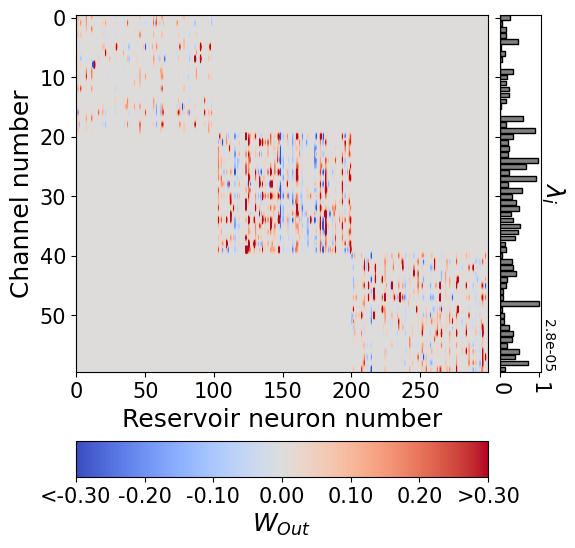

In [55]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2, width_ratios=(10, 1),wspace=0.05,height_ratios=(10,1),hspace=0.35)
# Create the Axes.
ax = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)

#wout = 2*((wout-np.min(wout))/(np.max(wout)-np.min(wout)))-1

image=ax.imshow(wout,aspect='auto',vmax=0.3,vmin=-0.3,cmap='coolwarm')
cb = plt.colorbar(
    image,
    cax=plt.subplot(gs[1, 0]),orientation='horizontal')

max_value_lambda_str = str(max_value_lambda)
to_add = max_value_lambda_str[:3]+max_value_lambda_str[-4:]

ax_histy.barh(list(range(len(lambda_vec))),(lambda_vec-np.min(lambda_vec))/(np.max(lambda_vec)-np.min(lambda_vec)),color='grey',edgecolor='black')
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_xticklabels([0,1], rotation = 270)
ax_histy.yaxis.set_label_position('right')
ax_histy.set_ylabel(r'$\lambda_i$',rotation=270,labelpad=18)
ax_histy.text(1.05,59,to_add,rotation=270)
ax.set_ylabel('Channel number')
ax.set_xlabel('Reservoir neuron number')
cb.set_label(r'$W_{Out}$')
ticks =  ["%.2f" % number for number in cb.get_ticks()] 

ticks[0] = f'<{ticks[0]}'
ticks[-1]= f'>{ticks[-1]}'
cb.set_ticklabels(ticks)
plt.savefig(os.path.join(OUTPUT_PATH,'training_description_final.pdf'),dpi=300)

In [212]:
x =  np.concatenate(mm.results['tr_states'],axis=0)

In [234]:
y = np.concatenate(training,axis=1)

In [ ]:
pred = ln.forward(x)

In [ ]:
adjust_font_dimension(title_size=20,legend_size=25,label_size=18,x_ticks=15,y_ticks=15)

(60, 7805)

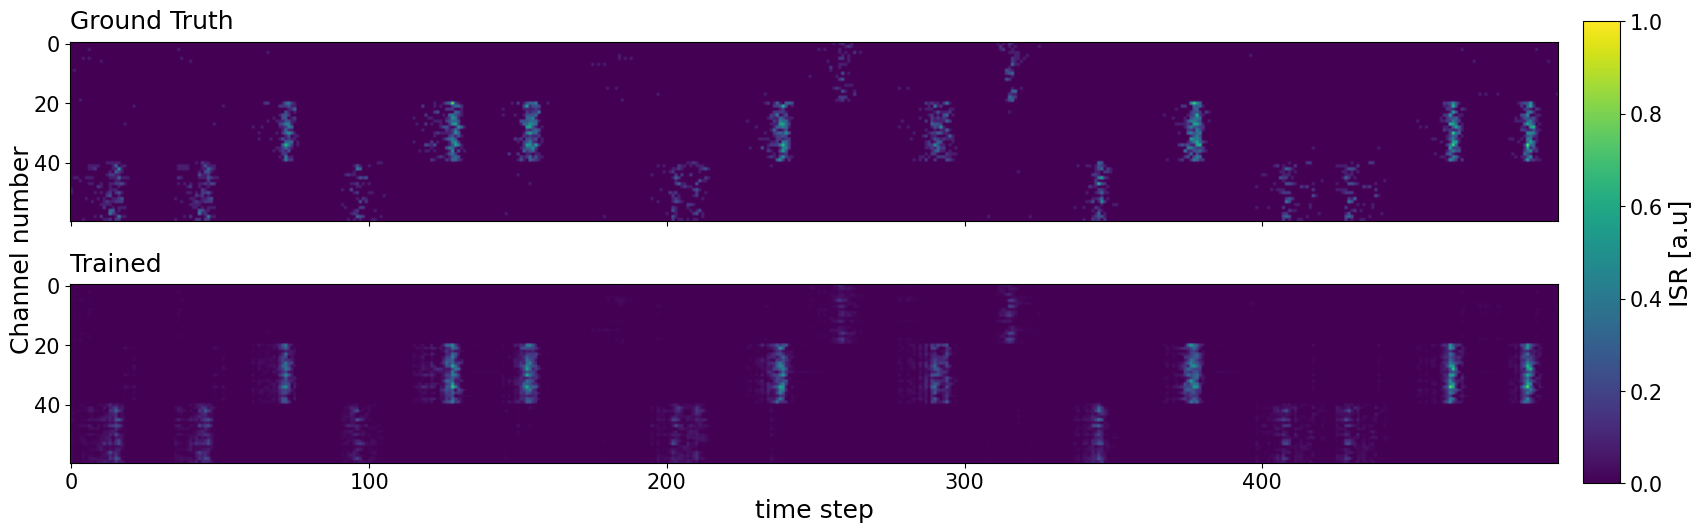

In [379]:
fig = plt.figure(figsize=(20, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 3, width_ratios=(10,10, 0.5),wspace=0.05,height_ratios=(1,1),hspace=0.1)
# Create the Axes.
ax = fig.add_subplot(gs[0, :2])
ax_2 = fig.add_subplot(gs[1, :2], sharex=ax)
y_step = y[:,:500]

pred_step = dc[:,:500]

im = ax.imshow(y_step,vmin=0,vmax=1)
ax_2.imshow(pred_step,vmin=0,vmax=1)
cb = plt.colorbar(
    im,
    cax=plt.subplot(gs[:, 2]))

ax.tick_params(axis="x", labelbottom=False)
fig.text(0.095, 0.5, "Channel number", rotation="vertical", va="center",fontsize=18)
ax_2.set_xlabel('time step')
cb.set_label('ISR [a.u]')
fig.text(0.125, 0.475, "Trained", va="center",fontsize=18)
fig.text(0.125, 0.88, "Ground Truth", va="center",fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH,'gt_trained_nb.pdf'),dpi=300)







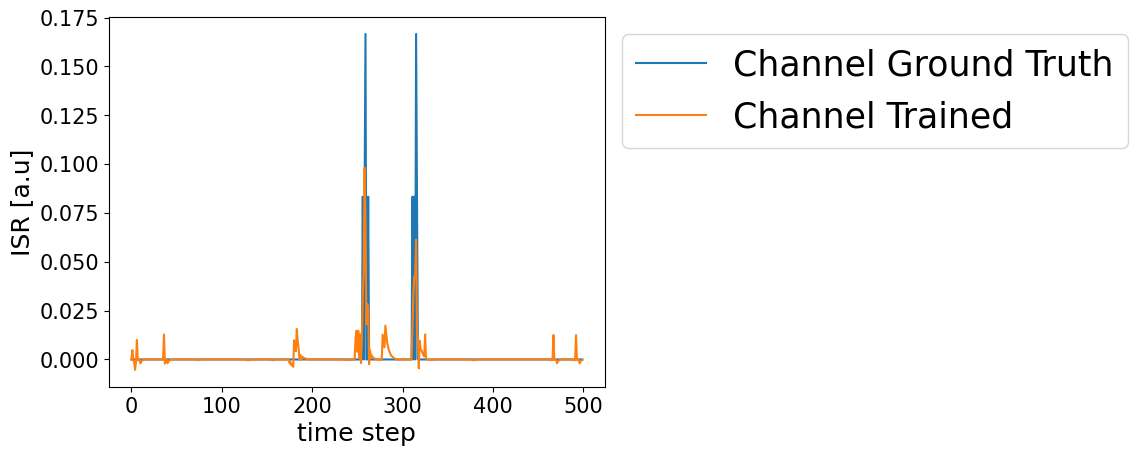

In [383]:
plt.plot(y[0,:500],label='Channel Ground Truth')
plt.plot(dc[0,:500],label='Channel Trained')
plt.xlabel('time step')
plt.ylabel('ISR [a.u]')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(OUTPUT_PATH,'gt_trained_channel.pdf'),dpi=300,bbox_inches='tight')

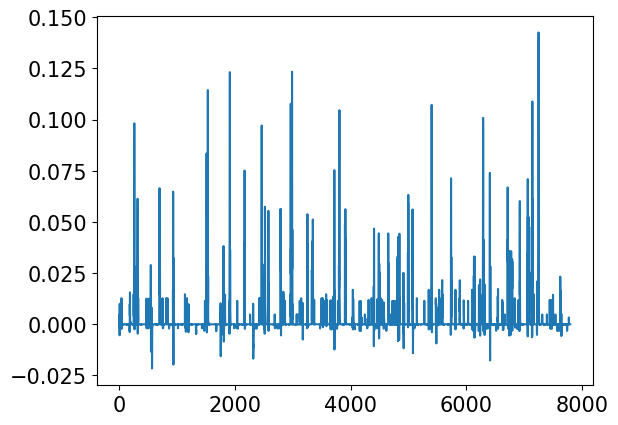

In [280]:
plt.plot(dc[0,:])

After training is complete we can use the MEArc model to predict the response of the simulated network (or experimetally recorded network) to a stimulus, and display the connectivity matrix.


In [24]:
cms = anl.connectivity_matrix_analysis(mearc_characterized_dict,exp_type=exp.exp_type)
# running this function creates a folder in the output folder called cm_analysis 
# where all data regarding CM analysis are stored

The connectivity matrix obtained from the model is then compared with the ground truth connectivity matrix of the simulated neural network (comparison between predicted and ground truth connectivity matrix can be done just for simulation, not for experimentally recorded network).

As metrics to compare the predicted and ground truth CM, we used the AUC and Pearson corr.coefficient between the two. 
Furthermore, the confidence measure the variability in CM prediction between the different MEArc model replicas.



AUC             |  Pearson         | Confidence
:-------------------------:|:-------------------------:|:-------------------------:|
![](simulation_example/figures_analysis_noteboook/AUC.svg)  |  ![](simulation_example/figures_analysis_noteboook/pearson.svg) | ![](simulation_example/figures_analysis_noteboook/confidence.svg)

All results are stored in the cm_analysis.csv file 

|m  |alpha|pearson           |AUC               |confidence         |
|---|-----|------------------|------------------|-------------------|
|1  |0.2  |0.7062343039081931|0.9538109628898668|0.7355924104559135 |
|1  |0.5  |0.6547714560754494|0.9370780259687488|0.5977443999101204 |
|1  |0.8  |0.5922772328676248|0.9158065440666959|0.48054510302088305|
|5  |0.2  |0.7234265756135727|0.9461360692790206|0.8264815849031129 |
|5  |0.5  |0.7198120053613895|0.9484905982099777|0.8359216036577327 |
|5  |0.8  |0.6960078347512499|0.9472353331712856|0.7636532388783689 |

Let's now stimulate the trained MEArc models obtaining the stimulation prediction

In [25]:
anl.stimulate_mearc(mearc_characterized_dict,analyzed_stim_dict,20)

In [26]:
predicted_stim = exp.get_data('predicted_psth')

now we can compare the ground truth PSTH with the predicted one

In [27]:
anl.full_characterization_stim(predicted_stim,analyzed_stim_dict)
# running this function creates a folder in the output folder called stimulus_prediction 
# where all data regarding stimulus prediction analysis are stored

Once all the steps are done we can save the exp instance as a pickle file

In [28]:
exp.exp_path=''
tmp_path = exp.results_path
exp.results_path=''
save_pickle_file(exp,os.path.join(tmp_path,'analyzed_experiment.pickle'))


we can now look to some of the plots obtained. Let's check prediction for stimulation of channel 11 for example.

We can see single channel prediction for MEArc model with m=5 and alpha=0.5 as an example

Channel 1
![](simulation_example/figures_analysis_noteboook/channel_1_prediction.svg)   

Channel 23
![](simulation_example/figures_analysis_noteboook/channel_23_prediction.svg) 

Channel 27
![](simulation_example/figures_analysis_noteboook/channel_27_prediction.svg)

we can even look for the same channel at the results across all m values or alpha values.

fixed alpha = 0.5 and different m 
![](simulation_example/figures_analysis_noteboook/channel_16_all_m_α_0.5_prediction.svg)

fixed m=5, different alpha
![](simulation_example/figures_analysis_noteboook/channel_16_m_5_all_alpha_prediction.svg)

Spatial response

|  Ground truth         | Prediction
:-------------------------:|:-------------------------:|
![](simulation_example/figures_analysis_noteboook/binarized_gt.png)  |  ![](simulation_example/figures_analysis_noteboook/binarized_prediction.png) | 

row and column axis indicate simulated channels index

The model prediction are compared with ground truth by using different metrics and everything is saved in csv file (below an example of csv result file)

||stim|m  |alpha|intensity|xrmse              |tau                |auc               |cc                |
|------|----|---|-----|---------|-------------------|-------------------|------------------|------------------|
|0     |19  |1  |0.2  |2.0      |0.06717831781747934|9.00208295797069   |0.6266666666666666|0.7043678552007531|
|1     |19  |1  |0.5  |2.0      |0.06080746382175893|7.6808305769298935 |0.6192592592592592|0.7754308625904085|
|2     |19  |1  |0.8  |3.0      |0.05437977717349353|-4.4957203699988115|0.8155555555555556|0.8158546998433744|
|3     |19  |5  |0.2  |2.0      |0.06257399038823169|8.651295562305526  |0.6066666666666666|0.8070767601869001|
|4     |19  |5  |0.5  |1.5      |0.05834449387869422|7.881560584232093  |0.591111111111111 |0.7498985142837842|
|5     |19  |5  |0.8  |1.5      |0.05097147426812754|-4.471923988384568 |0.7207407407407407|0.8461999841045504|
|6     |11  |1  |0.2  |30.0     |0.2236857483899629 |2.0092345551716333 |0.9993581514762515|0.8817209179042311|
|7     |11  |1  |0.5  |30.0     |0.23429441793303016|2.520880050124134  |1.0               |0.7879775374667718|
|8     |11  |1  |0.8  |30.0     |0.2340677032513505 |1.1481604705995272 |0.8780487804878049|0.6541414799717146|
|9     |11  |5  |0.2  |45.0     |0.21908827318029636|2.6593367884350623 |0.9987163029525032|0.7849749271849589|
|10    |11  |5  |0.5  |45.0     |0.21560292547322712|2.277846925295646  |1.0               |0.8081191252391845|
|11    |11  |5  |0.8  |45.0     |0.19022349650053777|2.004782652486825  |1.0               |0.780452133518918 |
|12    |14  |1  |0.2  |40.0     |0.13457678596654896|3.2967328089235113 |0.9722222222222222|0.6421502294360046|
|13    |14  |1  |0.5  |40.0     |0.12386589062945284|3.458363617075352  |0.9722222222222222|0.6737658173987725|
|14    |14  |1  |0.8  |40.0     |0.10790567238711082|2.6997275900643216 |0.8326719576719577|0.7427489184924735|
|15    |14  |5  |0.2  |45.0     |0.12599322846925087|3.712526036350213  |0.9947089947089947|0.7071921750715454|
|16    |14  |5  |0.5  |45.0     |0.12771644029059445|2.1073434421870596 |0.968915343915344 |0.6462689105775782|
|17    |14  |5  |0.8  |45.0     |0.13747639086849914|3.3732788330389734 |0.9398148148148148|0.5736807204496691|


other plots can be found in the stimulus_prediction folder in the corresponding output folder.

Results for both connectivity matrix analisys and stimulus prediction are saved as pickel file in the correspective folder (cm_analysis and stimulus_prediction).

The calculated connectivity matrix can be simply exported as npy or mat file. 
It's enough to specify the desired m and alpha value of the MEArc model for which the Connectivity matrix wants to be saved.

Starting from the cm_analysis_results.pickle file is possible to replot the data if the graphs are lost.

In [4]:
from data_prep.utils import export_cm_matrix

export_cm_matrix('simulation_example/results_example/60_pop_stim_full_inh__isol_pto_1_20240526192441/cm_analysis/cm_analysis_results.pickle',m=5,a=0.5,output_path='simulation_example/results_example/60_pop_stim_full_inh__isol_pto_1_20240526192441/cm_analysis')

In [ ]:
# Re-PLOT CM ANALYSIS
adjust_font_dimension(title_size=20,legend_size=25,label_size=18,x_ticks=15,y_ticks=15)

plot_single_exp_cm_analysis('simulation_example/results_example/60_pop_stim_full_inh__isol_pto_1_20240526192441/cm_analysis/cm_analysis_results.pickle',
                            '')



In [31]:
# plot all channels prediction
plot_channel_prediction('simulation_example/results_example/60_pop_stim_full_inh__isol_pto_1_20240526192441/analyzed_experiment.pickle',
                        stim_protocol=11,
                        m=5,
                        alpha=0.5,
                        intensity=45,
                        output_path='simulation_example/results_example/60_pop_stim_full_inh__isol_pto_1_20240526192441')